In [1]:
%run setup.py

# Read in modelling data (KIC 8367834, aka sapphire)

In [3]:
import h5py
d = h5py.File(work_dir+'modelling/sapphire/results/sapphire/data.h5', 'r')
cols = ['Dnu_freq', 'Dnu_freq_sc', 'FeH', 'Teff', 'Yinit', \
        'acoustic_cutoff', 'amlt', 'chi2', 'chi2_nonseis', \
        'chi2_seis_l0', 'delta_nu_scaling', 'index', 'lnprior', \
        'lnprob', 'log_g', 'luminosity', 'numax_scaling', 'prob', \
        'profile_number', 'radius', 'star_age', 'star_mass', \
        'surf_a1', 'surf_a3', 'surf_corr_at_1p1_numax', 'surf_corr_at_numax']
models = pd.DataFrame(np.array([d[col][:] for col in cols]).T, columns=cols)

In [4]:
models['nike'] = models['numax_scaling']**0.75/models['Dnu_freq']
models = models.sort_values('prob', ascending=True)

# Define fundamental stellar parameters

In [6]:
lum_J, e_lum_J, lum_K, e_lum_K = 32.87333062666726, 1.224742948548574, 32.40858950546034, 1.1570010736098393

Dnu, e_Dnu = 4.293468, 0.057175 #4.28687, 0.00729
numax, e_numax = 28.83, 0.66
mh, e_mh = 0.19442, 0.05
nike, e_nike = 2.902306, 0.050075
ra, dec = 292.68353, 44.344009

Teff, e_Teff = 4697, 46

numax_sun = 3090
Teff_sun = 5777
grav_sun = 28.02*980.665

grav = (numax/numax_sun) * (Teff/Teff_sun)**0.5
e_grav = ((e_numax/numax*1.)**2. + (e_Teff/Teff*0.5)**2.)**0.5 * grav

logg = np.log10(grav*grav_sun)
e_logg = e_grav/(np.log(10)*grav)

jmag, hmag, kmag = 8.877, 8.391, 8.228
e_jmag, e_hmag, e_kmag = 0.019, 0.023, 0.015


'''
# This is the pacakge to calculate the correction to the Dnu scaling relation
# http://www.physics.usyd.edu.au/k2gap/Asfgrid/

from fdnu import asfgrid

evstate=2
s=asfgrid.Seism(datadir=work_dir+"fdnu/")
mass_fdnu, radius_fdnu = s.get_mass_radius(evstate,mh,Teff,Dnu,numax,fill_value='linear',isfeh=True)

'''

mass_fdnu, radius_fdnu = 0.60785, 8.5001

lum_fdnu =  (radius_fdnu)**2. *(Teff/Teff_sun)**4.
logg_fdnu = np.log10(mass_fdnu/radius_fdnu**2. * grav_sun)

e_mass_fdnu = ((3*e_numax/numax)**2. + (4*e_Dnu/Dnu)**2. + (1.5*e_Teff/Teff)**2.)**0.5 * mass_fdnu
e_radius_fdnu = ((1*e_numax/numax)**2. + (2*e_Dnu/Dnu)**2. + (0.5*e_Teff/Teff)**2.)**0.5 * radius_fdnu
e_lum_fdnu = ((2*e_radius_fdnu/radius_fdnu)**2. + (4*e_Teff/Teff)**2.)**0.5 * lum_fdnu

# Plot Extended Figure 4 - modelling probability distributions

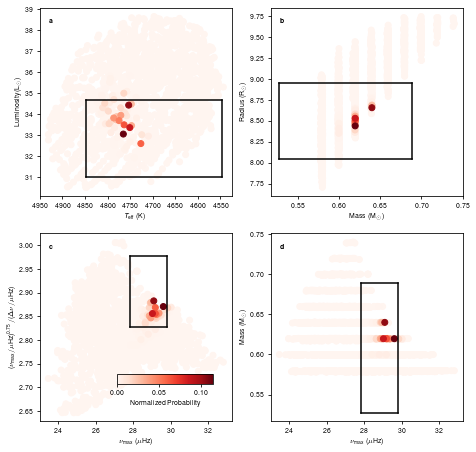

In [8]:
gridspec_kw = {'left':0.09, 'right':0.92, 'top':0.98, 'bottom':0.08, 'wspace':0.2, 'hspace':0.2}

fig, axes = plt.subplots(figsize=nature_size('double', ratio=0.9), nrows=2, ncols=2, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

def plot_error_box(ax, x, xerr, y, yerr):
    w = 1.5
    ax.plot([x-w*xerr, x-w*xerr], [y-w*yerr, y+w*yerr], 'k-')
    ax.plot([x+w*xerr, x+w*xerr], [y-w*yerr, y+w*yerr], 'k-')
    ax.plot([x-w*xerr, x+w*xerr], [y-w*yerr, y-w*yerr], 'k-')
    ax.plot([x-w*xerr, x+w*xerr], [y+w*yerr, y+w*yerr], 'k-')
    

axes[0].scatter(models['Teff'], models['luminosity'], c=models['prob'], cmap='Reds', rasterized=True)
axes[0].set_xlabel('$T_{\\rm eff}$ (K)')
axes[0].set_ylabel('Luminosity (L$_\\odot$)')
axes[0].set_xlim(axes[0].get_xlim()[::-1])
plot_error_box(axes[0], Teff, 100, lum_J, e_lum_J)

c=axes[1].scatter(models['star_mass'], models['radius'], c=models['prob'], cmap='Reds', rasterized=True)
axes[1].set_xlabel('Mass (M$_\\odot$)')
axes[1].set_ylabel('Radius (R$_\\odot$) ')
plot_error_box(axes[1], mass_fdnu, e_mass_fdnu, radius_fdnu, e_radius_fdnu)

axes[2].scatter(models['numax_scaling'], models['nike'], c=models['prob'], cmap='Reds', rasterized=True)
axes[2].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
axes[2].set_ylabel('$(\\nu_{\\rm max}/\\mu$Hz$)^{0.75}/(\\Delta\\nu/\\mu$Hz$)$ ')
plot_error_box(axes[2], numax, e_numax, nike, e_nike)

axes[3].scatter(models['numax_scaling'], models['star_mass'], c=models['prob'], cmap='Reds', rasterized=True)
axes[3].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
axes[3].set_ylabel('Mass (M$_\\odot$)')
plot_error_box(axes[3], numax, e_numax, mass_fdnu, e_mass_fdnu)

cax = axes[2].inset_axes([0.4, 0.2, 0.5, 0.05], transform=axes[2].transAxes)
fig.colorbar(c, cax=cax, ax=axes[1], orientation='horizontal').set_label('Normalized Probability')

labels = ['{\\textbf{a}}', '{\\textbf{b}}', '{\\textbf{c}}', '{\\textbf{d}}']
for iax, ax in enumerate(axes):
    ax.text(0.05, 0.92, labels[iax], transform=ax.transAxes, fontsize=fontsize)
        
plt.savefig(overleaf_path+'Fig_extended_4_sapphire.pdf')